### Introduction

Forecasting energy prices in Germany is a challenging task due to the complex interplay of multiple factors, including renewable energy generation, fossil fuel prices, weather conditions, and market regulations. The growing share of renewables in the country’s power grid has introduced additional volatility, making accurate price prediction even more difficult.

Our project, the “BTW 2025 Data Science Challenge,” aims to develop predictive models to predict hourly day-ahead energy prices for Germany on February 18, 2025, using historical data. This report begins with an overview of the domain knowledge surrounding Germany’s energy market, followed by a discussion of the data sources used in modeling. Subsequent sections will detail the methodology, present modeling results, and offer conclusions.

#TO DO: Rewrite second part: It is a part of the challenge not our project - we are participating in the data science challenge etc.

In [1]:
import pandas as pd
from prophet import Prophet
from datetime import timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mae, init_prophet_model, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

from src.scraping import update_e_mix_data, update_e_price_data, fetch_historical_weather
from src.benchmark import extend_by_predictions_and_samples
from src.final_prediction import fill_up_e_prices, fill_up_energy_mix

In [3]:
update_e_price_data()
update_e_mix_data()
fetch_historical_weather()

Starting update_smard_data function...
Loading existing data...
Loaded 1 existing records.
Fetching data for the past 332 weeks...
Fetching data for week 1 (starting 2025-02-03)...
Successfully fetched data.
Skipping invalid data point: ts=1738882800000, price=None
Skipping invalid data point: ts=1738886400000, price=None
Skipping invalid data point: ts=1738890000000, price=None
Skipping invalid data point: ts=1738893600000, price=None
Skipping invalid data point: ts=1738897200000, price=None
Skipping invalid data point: ts=1738900800000, price=None
Skipping invalid data point: ts=1738904400000, price=None
Skipping invalid data point: ts=1738908000000, price=None
Skipping invalid data point: ts=1738911600000, price=None
Skipping invalid data point: ts=1738915200000, price=None
Skipping invalid data point: ts=1738918800000, price=None
Skipping invalid data point: ts=1738922400000, price=None
Skipping invalid data point: ts=1738926000000, price=None
Skipping invalid data point: ts=173892

/Users/boh/code/LSDI-Project-/hand_in/src/scraping.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(how='all', inplace=True)


Historical data appended to ./data/germany_weather_average.csv.


/Users/boh/code/LSDI-Project-/hand_in/src/scraping.py:385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(inplace=True)


## 1. Background & Domain Knowledge

### 1.1 Energy Market and Price Dynamics
In Germany, electricity pricing comprises consumer electricity fees and wholesale market prices, with the day-ahead market being a key indicator of wholesale price fluctuations. Prices in this market are determined by the “merit order principle,” in which power plants with the lowest marginal costs are utilized first to meet demand. Because renewable energy sources generally have low marginal costs, they are dispatched preferentially. However, oversupply in addition of limitations in the grid can lead to negative prices (Wissenschaftliche Dienste, 2022).

**These dynamics underscore the importance of closely examining both supply-side and demand-side variables when forecasting energy prices.** # TO DO: decide if we include demand in the background knowledge

#TO DO: Price determined by last power plant

### 1.2 Energy Mix
Germany’s energy mix has evolved significantly, with the share of renewables reaching about 50% of total generation in 2023 (BMWK-Energiewende, 2024). Among these, wind and solar power dominate:
- Wind Power: Peaks during winter to spring due to higher wind speeds, typically exerting downward pressure on prices (Clean Energy Wire).
- Solar Power: Generates more electricity in summer, reducing prices during daylight hours (Sebastian Kolb, 2020; IMF, 2022).

Despite the rise in renewables, fossil fuels—including hard coal, lignite, and natural gas—still play a critical role. They contribute to price volatility, influenced by fluctuating fuel costs and carbon pricing (Nature, 2024). Understanding both the renewable and fossil-fuel components of the energy mix is therefore crucial for accurate price forecasting.

#TO DO: Add hyptothesis on how the energy mix influences the prices

#TO DO: check sources, decide if we keep the sources because proof is in our model results

<Figure size 1400x600 with 0 Axes>

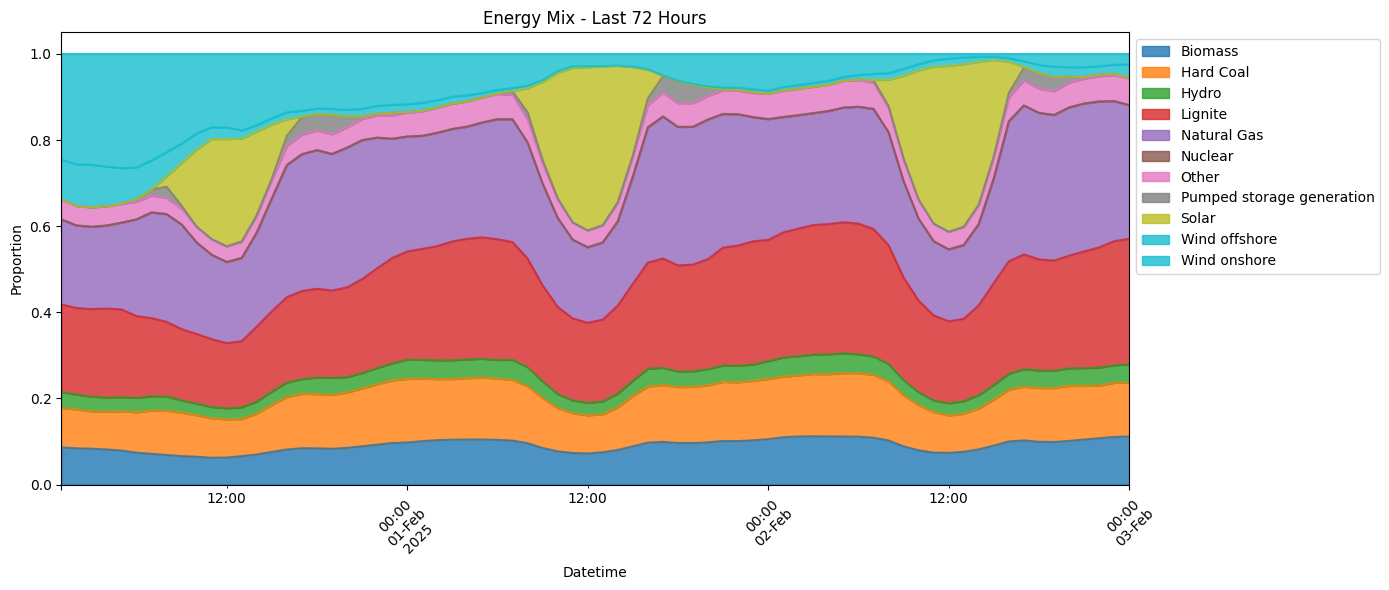

In [4]:
# Rename the timestamp column and parse dates
df_raw =pd.read_csv('../data/hourly_market_mix_cleaned.csv')

df_raw.rename(columns={"Timestamp": "Datetime"}, inplace=True)
df_raw["Datetime"] = pd.to_datetime(df_raw["Datetime"])

# Ensure the dataframe is sorted by datetime
df_raw = df_raw.sort_values(by="Datetime")

# Select the last 72 hours
df_last_72h = df_raw.tail(72)

# Set Datetime as index
df_last_72h.set_index("Datetime", inplace=True)

# Normalize the energy sources to get proportions
df_normalized = df_last_72h.div(df_last_72h.sum(axis=1), axis=0)

# Plot the stacked area chart
plt.figure(figsize=(14, 6))
df_normalized.plot.area(figsize=(14, 6), alpha=0.8, cmap="tab10")
plt.xlabel("Datetime")
plt.ylabel("Proportion")
plt.title("Energy Mix - Last 72 Hours")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

This plot represents the proportional composition of different energy sources (production in Germany) over the last 72 hours. Each color represents a different energy source contributing to the total energy mix at a particular time.
#TO DO: Add underlining context to the plot


### 1.3 Weather Impacts
Weather conditions significantly affect energy supply and demand, thereby influencing prices. Key factors include:
- Wind Speeds: Higher winds, especially in northern Germany, boost renewable generation and typically lower prices (Tanaka et al., 2022; Mosquera-Lopez et al., 2024).
- Solar Irradiance: Stronger sunlight in southern regions increases solar power output, putting downward pressure on prices.
- Temperature:
  - Low Temperatures → Increased heating demand → Higher prices
  - High Temperatures → Increased cooling demand → Higher prices
- Precipitation: Affects prices with a delayed impact, possibly by influencing hydropower generation or overall energy demand (Mosquera-Lopez et al., 2024; Springer, 2022; IMF, 2022).

## 2. Data Cleaning

Understanding and preparing the data is a crucial step in any predictive modeling task. In energy price forecasting, data reliability, completeness, and structure play a fundamental role in ensuring the models can capture key trends and dependencies. Given the complexity of the energy market, multiple data sources were used, each contributing essential information. However, some critical datasets were not readily accessible—gas and oil price data were behind a paywall, preventing their inclusion, and electricity demand data was available but consistently missing the last three days, making it unreliable for modeling. Addressing these challenges required careful data cleaning, merging, and feature engineering to build a robust foundation for forecasting models.



## 2.1 Data Sources & Reliabality

Ensuring the reliability of data sources is fundamental in energy price modeling. The datasets used in this analysis are sourced from reputable organizations: Energy prices are sourced from SMARD.de, a platform operated by the German Federal Network Agency, which is recommended for energy price data. Weather data is obtained from Open-Meteo, a provider of historical and forecast weather information that collaborates with national weather services. Data on the energy mix is provided by Agora Energiewende, which offers interactive tools and datasets widely used for analyzing energy mix information. (SMARD, 2025) (Agora Energiewende, 2025)


## 2.2 Data Cleaning and Preparation
To ensure the datasets were ready for analysis, a thorough data cleaning process was carried out. The first step involved handling missing data. One notable challenge was the absence of nuclear energy data after April 15, 2023, due to Germany’s nuclear phase-out. Additionally, any missing values in other datasets were addressed by re-fetching the data from their respective sources to maintain completeness. Ensuring a fully populated dataset was crucial for maintaining consistency across all variables and enabling reliable model training.
Another key aspect was outlier detection. Given the inherent volatility of energy prices, extreme values were carefully examined rather than being removed outright. Instead of discarding outliers indiscriminately, we assessed their impact on the model’s performance. In some cases, extreme values contained meaningful signals about rare market conditions and were retained to ensure the model could adapt to such situations. Each outlier was evaluated in context, preserving those that could provide valuable insights while mitigating the effect of spurious anomalies.
After cleaning the data, we merged different datasets to establish a comprehensive dataset for modeling. Weather data, energy price data, and energy mix data were aligned by date, ensuring that all records were synchronized correctly. This step was crucial for creating a structured dataset that allowed for meaningful feature extraction and analysis in the subsequent modeling phase.


## 2.3 Correlation Analysis
We explored the relationship between different factors (weather variables, energy mix) and energy prices. Initial findings revealed an inverse correlation between renewable energy generation (solar, wind onshore, wind offshore, hydro) and energy prices, with an observed moderate negative correlation coefficient of -0.312. (pic a)



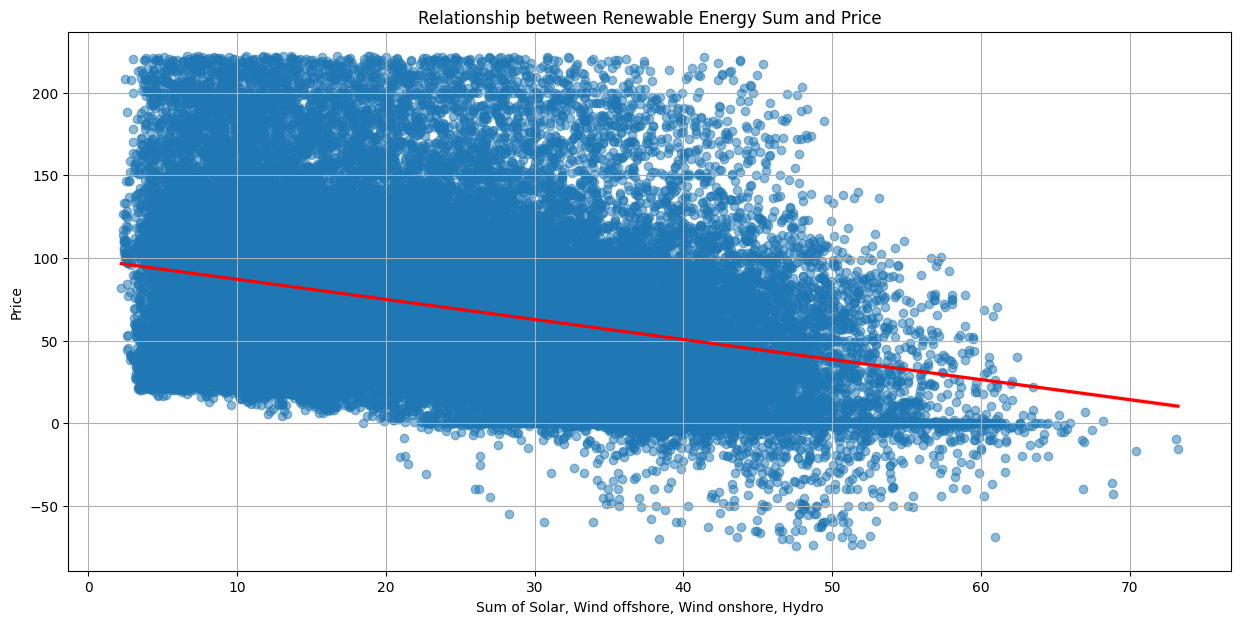

(-0.30497358159480326, 1.1102230246251565e-16)

In [5]:
price_df = pd.read_csv('../data/day_ahead_energy_prices.csv')
price_df.rename(columns={"Datetime": "Timestamp", "hourly day-ahead energy price": "Price"}, inplace=True)

min_price = -74.44
max_price = 222.01

# Filter the dataframe to remove rows with energy prices outside the range
price_df = price_df[
    (price_df['Price'] >= min_price) &
    (price_df['Price'] <= max_price)
]

# energy_mix_df = pd.read_csv("../data/hourly_market_mix_delta_abs.csv")
energy_mix_df = pd.read_csv("../data/hourly_market_mix_cleaned.csv")
# Merge datasets on timestamp
merged_df = pd.merge(energy_mix_df, price_df, on='Timestamp', how='inner')

# Set the Timestamp column as the index
merged_df.set_index('Timestamp', inplace=True)

# Calculate the sum of the specified columns
min_price = -74.44
max_price = 222.01

# Filter the dataframe to remove rows with energy prices outside the range
merged_df = merged_df[
    (merged_df['Price'] >= min_price) &
    (merged_df['Price'] <= max_price)
]

merged_df['Renewable_Sum'] = merged_df[['Solar', 'Wind offshore', 'Wind onshore', 'Hydro']].sum(axis=1)
# Plot the relationship with a correlation line
plt.figure(figsize=(15, 7))
sns.regplot(x='Renewable_Sum', y='Price', data=merged_df, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title('Relationship between Renewable Energy Sum and Price')
plt.xlabel('Sum of Solar, Wind offshore, Wind onshore, Hydro')
plt.ylabel('Price')
plt.grid(True)
plt.show()

r, p_two_tailed = pearsonr(merged_df[['Solar', 'Wind offshore', 'Wind onshore', 'Hydro']].sum(axis=1), merged_df['Price'])

if p_two_tailed == 0.0:
    p_two_tailed = np.finfo(float).eps  # Assign the smallest positive float value

p_one_tailed = p_two_tailed / 2

r,  p_one_tailed

The following scatter plot shows a moderate negative correlation (r = -0.312) between renewable energy generation (solar, wind onshore, wind offshore, hydro) and electricity prices. While renewables lower prices due to their low marginal costs, other factors like demand, fossil fuel prices, and regulations also influence price fluctuations


#TO DO: Rewrite explanation for better strucutre and clarity

#TODO: make trendline for correlation of energy price and temp or wind speed

## Data loading

#DO TO: Explanation for removing outliers


In [6]:
merged_df, e_price_df = get_datasets()

In [7]:
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2018-10-01 00:00:00,59.53,5.319,8.294,1.166,15.866,8.697,7.929,2.309,0.194,0.0,1.650,4.372,9.660435,0.004348,17.720478,0.0
2018-10-01 01:00:00,56.10,5.284,7.975,1.131,15.927,8.787,7.941,2.341,0.194,0.0,2.115,4.080,9.375652,0.047826,16.909334,0.0
2018-10-01 02:00:00,51.41,5.291,7.797,1.118,16.009,9.019,7.962,2.336,0.194,0.0,2.176,3.995,9.129999,0.052174,18.927275,0.0
2018-10-01 03:00:00,47.38,5.279,8.214,1.128,16.078,8.605,7.871,2.329,0.194,0.0,2.234,4.268,8.856087,0.073913,19.802275,0.0
2018-10-01 04:00:00,47.59,5.293,8.523,1.127,16.139,8.373,7.895,2.339,0.194,0.0,2.600,4.722,8.758261,0.113043,20.606785,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03 20:00:00,167.74,4.790,5.514,2.108,12.753,20.576,0.000,2.943,1.413,0.0,2.562,4.223,-1.543913,0.000000,13.288947,0.0
2025-02-03 21:00:00,153.00,4.765,5.464,1.987,12.598,20.003,0.000,2.882,0.357,0.0,2.714,4.740,-1.761304,0.000000,13.424150,0.0
2025-02-03 22:00:00,144.23,4.756,5.401,2.010,12.601,19.063,0.000,2.791,0.164,0.0,2.957,4.805,-2.052609,0.000000,13.274910,0.0
2025-02-03 23:00:00,135.81,4.750,5.325,1.992,12.580,17.214,0.000,2.765,0.109,0.0,3.238,4.688,-2.337391,0.000000,13.408796,0.0


## Configuration


In [8]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2025, 2, 5), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## 3. Features
#TO DO: Feature selection - autoML

Selecting relevant features is crucial for building an effective predictive model. Given the diverse range of available data—including time-based attributes, moving averages, energy generation sources, and weather variables—our selection process focused on maximizing predictive power while avoiding redundancy.
Since energy prices exhibit strong temporal dependencies, time-based features were incorporated to capture seasonal and weekly patterns. The importance of these features has been previously discussed in the context of price dynamics (see Section 1.1.1). Additionally, moving averages played a key role in smoothing short-term fluctuations and enhancing model stability, as outlined in Section 3.1.
Beyond time-related attributes, energy mix variables were selected based on their direct impact on electricity prices. Renewable energy sources, particularly solar and hydro, were included due to their well-documented influence on price formation. Weather variables, such as temperature, precipitation, and direct radiation, were chosen for their role in both energy demand and renewable generation variability. These relationships have been analyzed in Section 1.1.3, reinforcing their relevance in predictive modeling.
By carefully curating our feature set, we ensured that the model balances complexity and interpretability while capturing the fundamental drivers of energy price fluctuations. This selection process aimed to improve forecasting accuracy without introducing unnecessary computational overhead.


## 3.1 Moving Averages and Their Role in Forecasting
Moving averages are essential for smoothing out short-term fluctuations in time-series data and revealing underlying trends. By averaging values over a defined window, moving averages reduce noise and enhance the visibility of long-term patterns.
For linear regression-based models, moving averages provide several benefits:
- *Noise Reduction*: Energy price data can be volatile due to external shocks, market fluctuations, and unexpected demand surges. Moving averages help smooth these fluctuations, enabling the model to focus on broader trends rather than reacting to random variations.
- *Feature Engineering*: Moving averages can serve as additional explanatory variables in regression models, capturing smoothed past behavior that informs future predictions.
Seasonality Handling: By choosing appropriate window sizes (e.g., 24-hour, 7-day, or 30-day moving averages), it is possible to better capture daily, weekly, or monthly cycles in energy prices.
- *Enhanced Interpretability*: Linear models often struggle with high-frequency variations. Incorporating moving averages helps them generalize better by reducing the emphasis on short-term noise.
Given the time-series nature of energy prices, we applied moving averages with various window sizes (e.g., hourly and daily) to analyze how different trends affect price fluctuations. This was particularly useful in identifying seasonal effects and ensuring that models could make robust predictions without overfitting to short-term anomalies.

In [9]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [10]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df.copy())
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df.copy(),eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



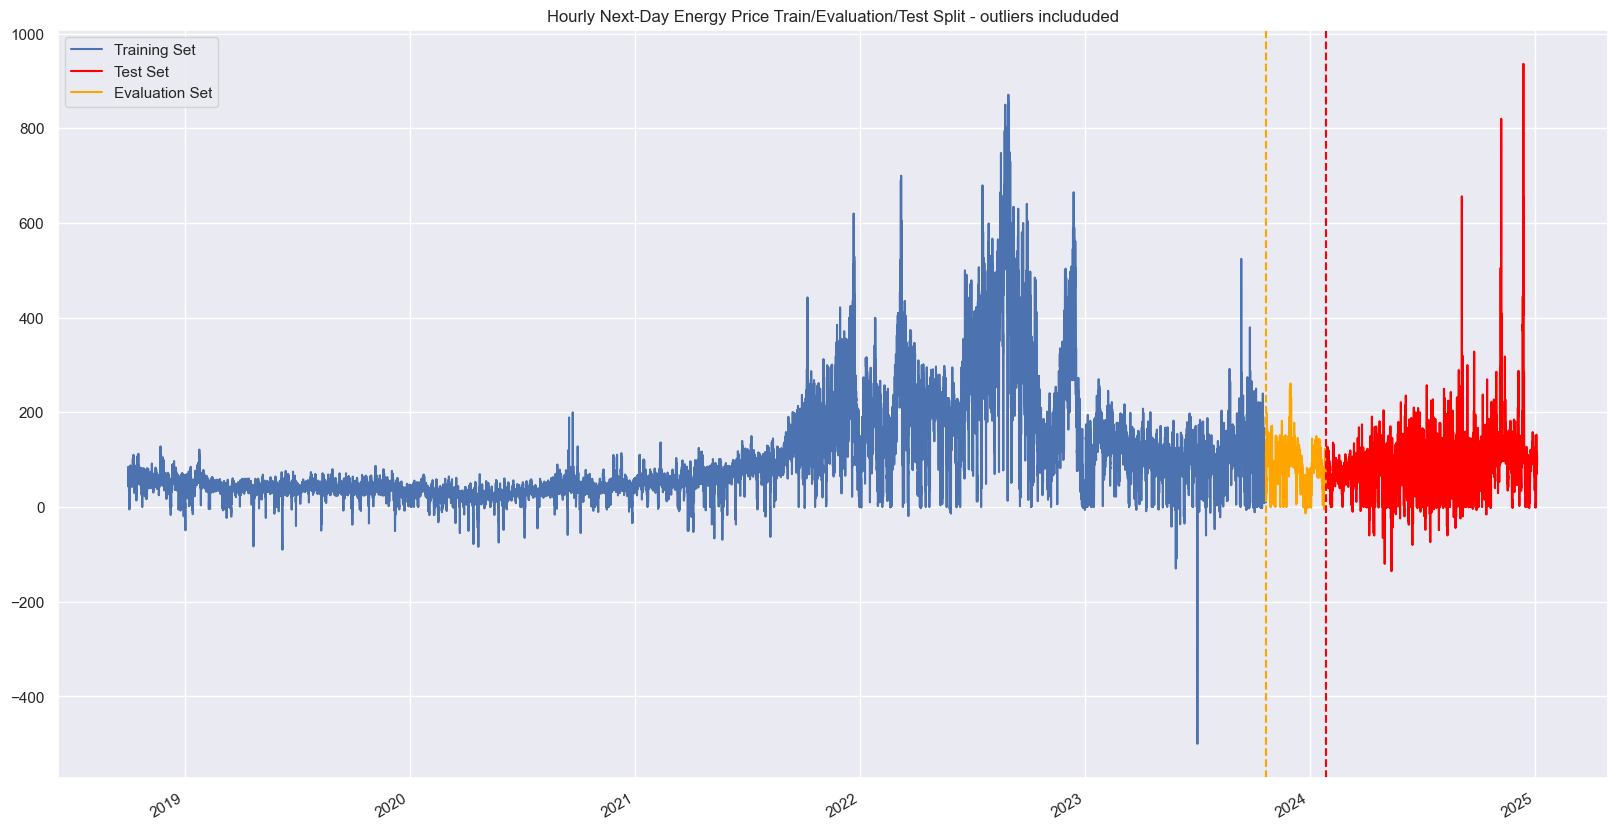

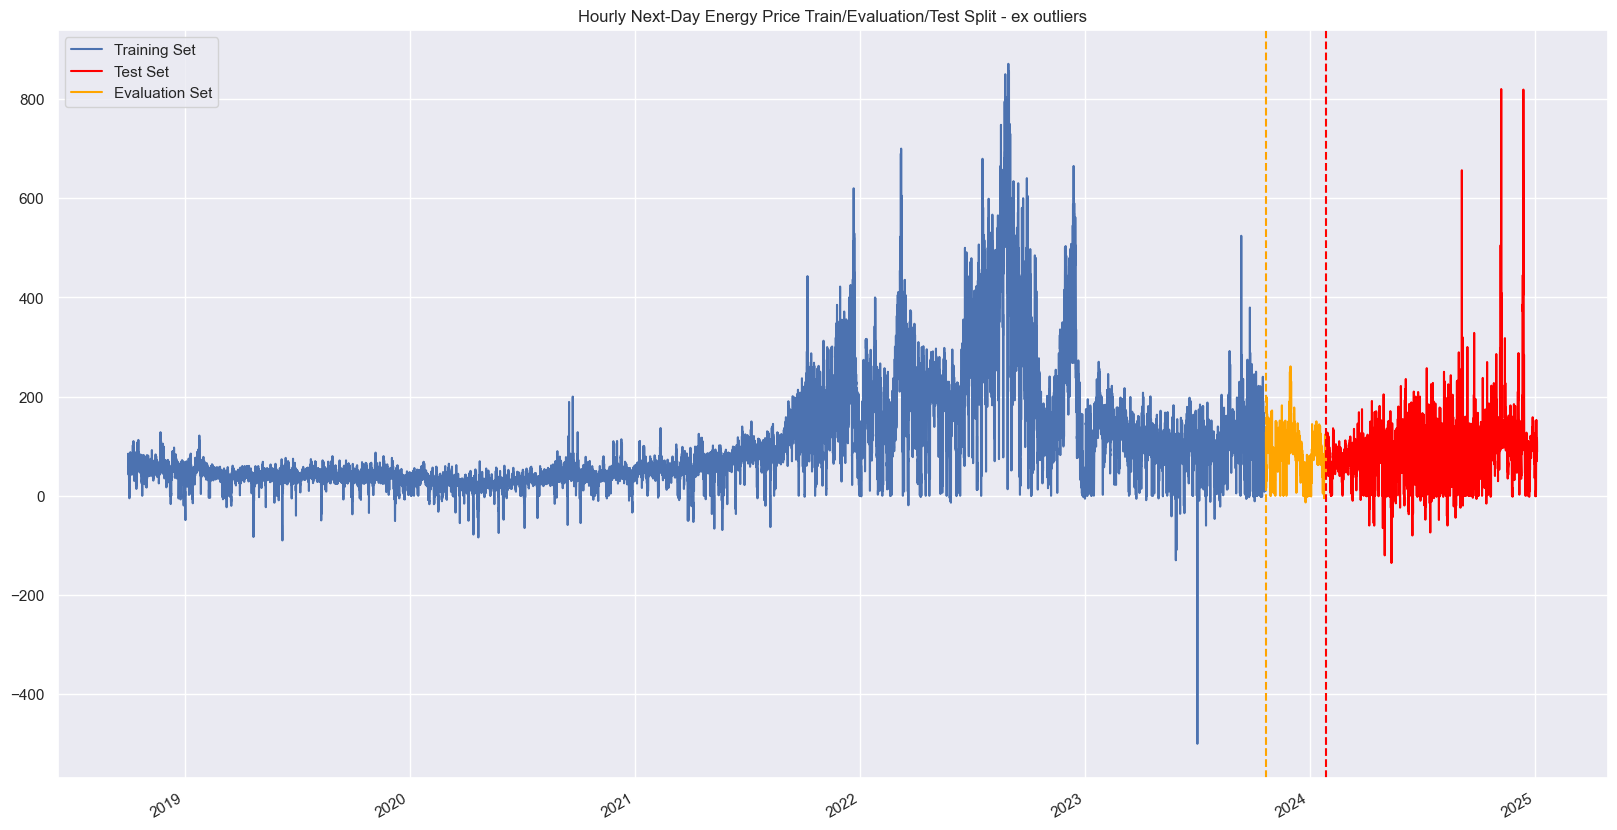

In [11]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## 3.2 Evaluation Criteria

To assess model performance, we considered the following:
1. Error Objectiv Functions
- RMSE (Root Mean Squared Error): Measures overall prediction error, with a stronger penalty for large deviations.
- MAE (Mean Absolute Error): Reflects the average magnitude of errors without emphasizing outliers as strongly as RMSE.
- MSE (Mean Squared Error): Calculates the average of the squared differences between actual and predicted values, providing a general measure of error while penalizing larger errors more than MAE.
- MAPE (Mean Absolute Percentage Error): Expresses the average absolute error as a percentage of actual values, making it useful for comparing errors across different scales or datasets.
2. Handling of Seasonality and Outliers
- The ability to capture daily, weekly, and yearly seasonality effectively.
- Robustness to price spikes and outliers due to external factors like demand surges or market shocks.
3. Ease of Interpretation
- Linear models like Regression provide direct insight into feature importance.
- Prophet allows for intuitive trend and seasonality decomposition.
- XGBoost requires careful feature engineering to extract meaningful insights.
4. Faster Iteration and Scalability
- Training time and computational efficiency.
- Ability to adapt and fine-tune hyperparameters efficiently.



## 4 Model Selection and Training


#TODO: Add Explanation about using benchmark model

Selecting an appropriate modeling approach is a critical step in building a reliable forecasting system. Given the complexity of energy price dynamics, the choice of models must balance accuracy, interpretability, and computational efficiency. A well-defined modeling strategy typically begins with a simple yet effective baseline model before progressing to more advanced techniques. This ensures that improvements gained from sophisticated models are measured against a meaningful reference point. In this section, we outline the reasoning behind our model selection process, beginning with a baseline model and advancing to more specialized forecasting methods.
## 4.1 Choosing a Baseline Model
For our initial baseline model, we selected Linear Regression due to its simplicity, interpretability, and computational efficiency. Linear Regression provides a straightforward approach to capturing linear relationships in the data, making it an excellent reference point for evaluating more complex models. However, it struggles with capturing non-linear dependencies and seasonality, which are crucial in energy price forecasting.
We opted against using neural networks due to several reasons:
- **Computational Cost**: Training deep learning models requires significant computational resources, which were not justified given the available dataset size and forecasting horizon.
- **Interpretability**: Neural networks act as black-box models, making it difficult to extract insights about seasonal trends, price spikes, or external influencing factors.
- **Data Requirements**: Deep learning models typically require large amounts of high-quality data to generalize well. Given our dataset’s structure, traditional time-series models were more suitable.
## 4.2 XGBoost
XGBoost (Extreme Gradient Boosting) is a machine learning algorithm based on decision trees, well-suited for structured datasets like ours. It excels at capturing non-linear relationships, allowing it to model complex interactions between features and energy prices, which Linear Regression cannot do. XGBoost also provides built-in feature importance metrics, helping identify key factors like weather, energy mix, and demand fluctuations. It handles missing data and outliers better than traditional models, making it a robust choice for real-world forecasting. Computationally efficient compared to deep learning models, XGBoost performs well for our dataset, although it requires feature engineering and hyperparameter tuning. Its ability to capture short-term fluctuations and complex feature interactions can enhance forecasting accuracy.

### TODO: add explanation fpr gradiant boosting
## 4.3 Prophet
Prophet, developed by Facebook, is designed for time-series forecasting, particularly in capturing seasonality, trends, and holiday effects. It automatically detects daily, weekly, and yearly seasonality, which is helpful for energy price forecasting, where such patterns dominate. Prophet is robust to missing data and outliers, improving forecast reliability. Unlike traditional models, Prophet allows trend changes over time, making it ideal for dynamic markets. It also provides clear decompositions of trend, seasonality, and holiday effects, offering interpretability that aids understanding of energy price drivers. Prophet’s combination of seasonality detection, trend flexibility, and ease of use makes it a powerful tool for forecasting energy prices.


### Linear Regression

In [12]:
# lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
# lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [13]:
# best_params = {
#     "base_score": 0.380924762889507,
#     "early_stopping_rounds": 215,
#     "max_depth": 80,
#     "learning_rate": 0.06,
#     "n_estimators": 150,
#     "gamma": 0.9,
#     "min_child_weight": 6,
#     "subsample": 0.5719023844219375,
#     "colsample_bytree": 0.8815691043681952,
# }
# xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
# xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)


### Prophet

In [14]:
# # Initialize Prophet model
# model = Prophet(
#     changepoint_prior_scale = 0.5,
#     seasonality_prior_scale = 1.0,
#     holidays_prior_scale = 1.0,
#     seasonality_mode= 'multiplicative'
# )

# #Add fourier order for weekly and monthly seasonality
# model.add_seasonality(name='weekly', period=7, fourier_order=20)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
# model.add_seasonality(name='yearly', period=365, fourier_order=20)

# # Add time-based regressors

# for feature in FEATURES:
#      model.add_regressor(feature)
     
# train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

# model.fit(train_data)

# test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
# test_data_prophet.drop(columns=["Price"])
# prophet_predictions = model.predict(test_data_prophet)["yhat"]


## Results

### Errors

In [15]:
# calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

### Plots

In [16]:
# predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

# plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

In [17]:
# feature_importance(xgb_mse, "MSE")
# feature_importance(xgb_mae, "MAE")

## Benchmarking - Energy Price Predictions on unseen days including sampled and predicted features data

18:23:25 - cmdstanpy - INFO - Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-05 00:00:00 to 2025-01-06 00:00:00


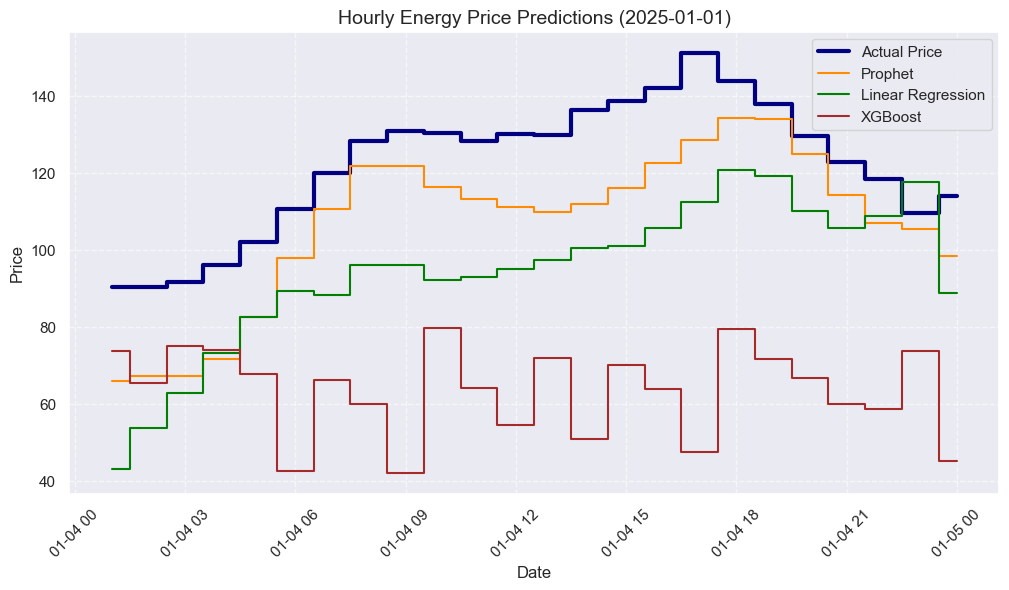

Prophet RMSE: 16.874414920215923
Linear Regression RMSE: 30.199332423434488
XGBoost RMSE: 62.44109016614521



18:24:39 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-05 23:00:00 to 2025-01-06 23:00:00


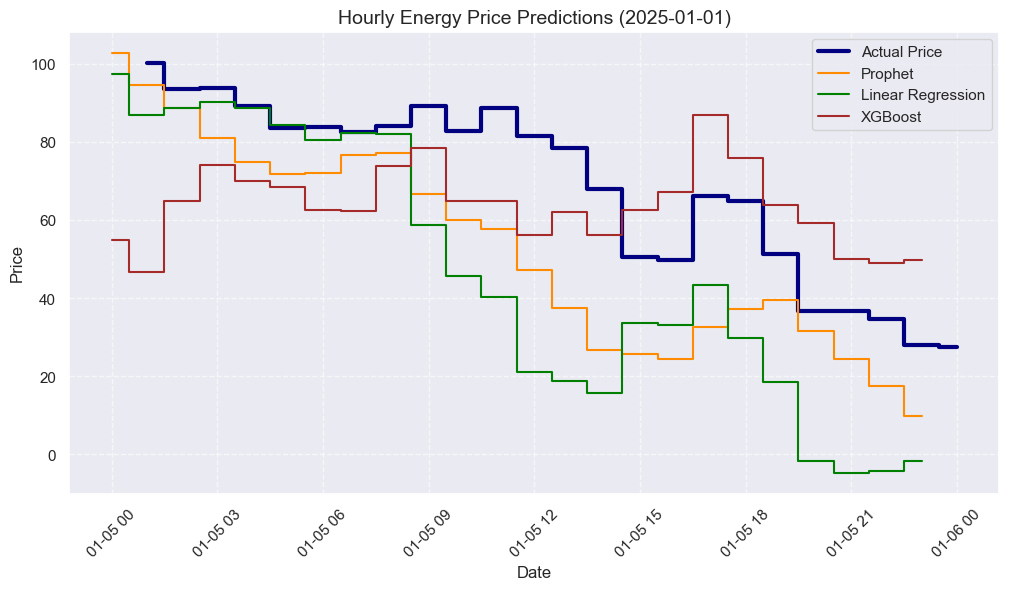

Prophet RMSE: 19.266786455757362
Linear Regression RMSE: 27.963638041662822
XGBoost RMSE: 22.284458983041716



18:25:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:49 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-07 00:00:00 to 2025-01-08 00:00:00


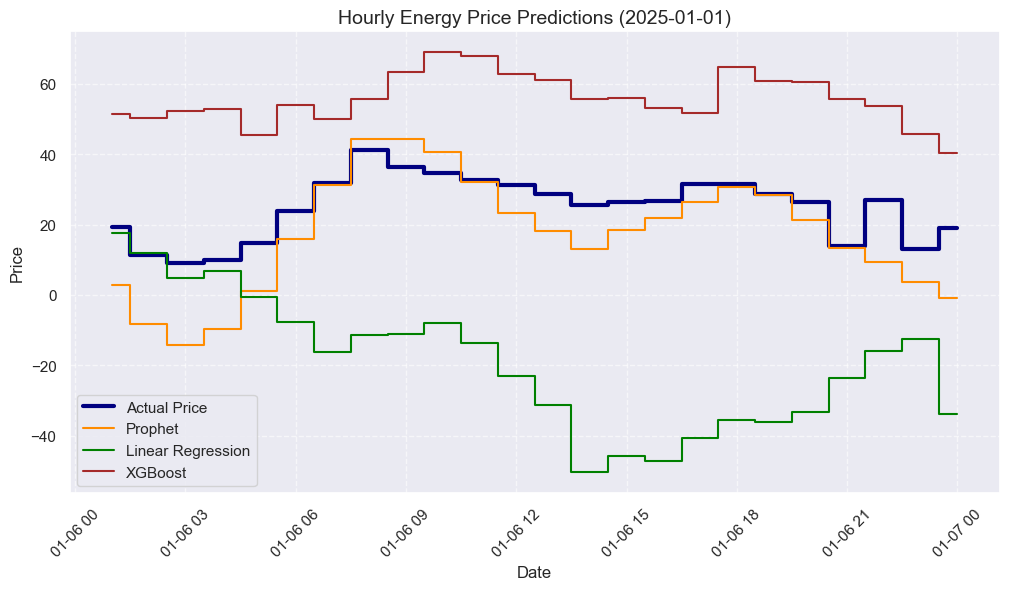

Prophet RMSE: 11.553472733578362
Linear Regression RMSE: 49.9021942812168
XGBoost RMSE: 31.652664307426022



18:27:03 - cmdstanpy - INFO - Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-08 00:00:00 to 2025-01-09 00:00:00


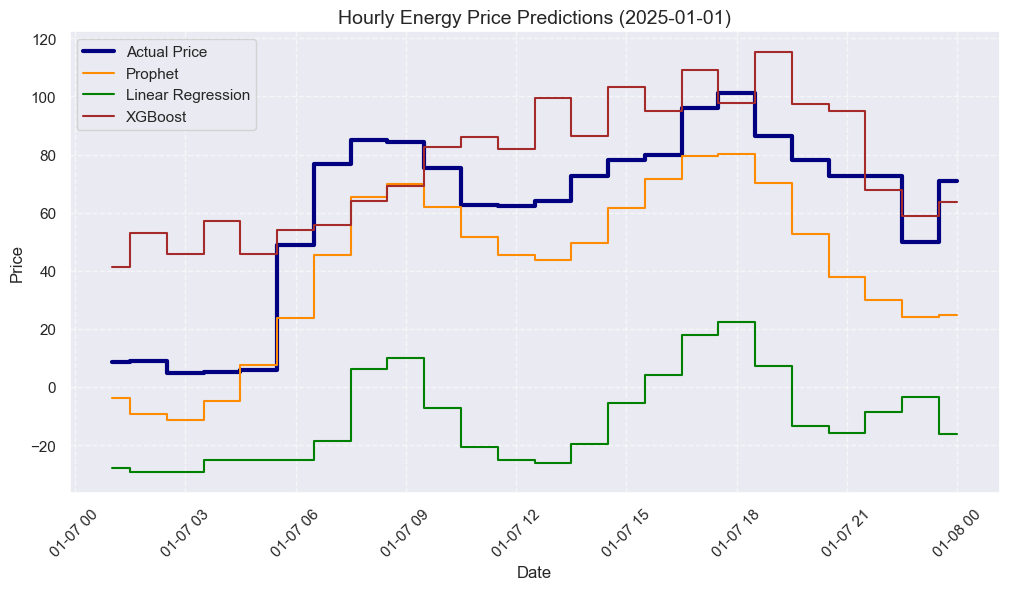

Prophet RMSE: 22.678096159908428
Linear Regression RMSE: 74.86484812598117
XGBoost RMSE: 25.357437292916106



18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-09 00:00:00 to 2025-01-10 00:00:00


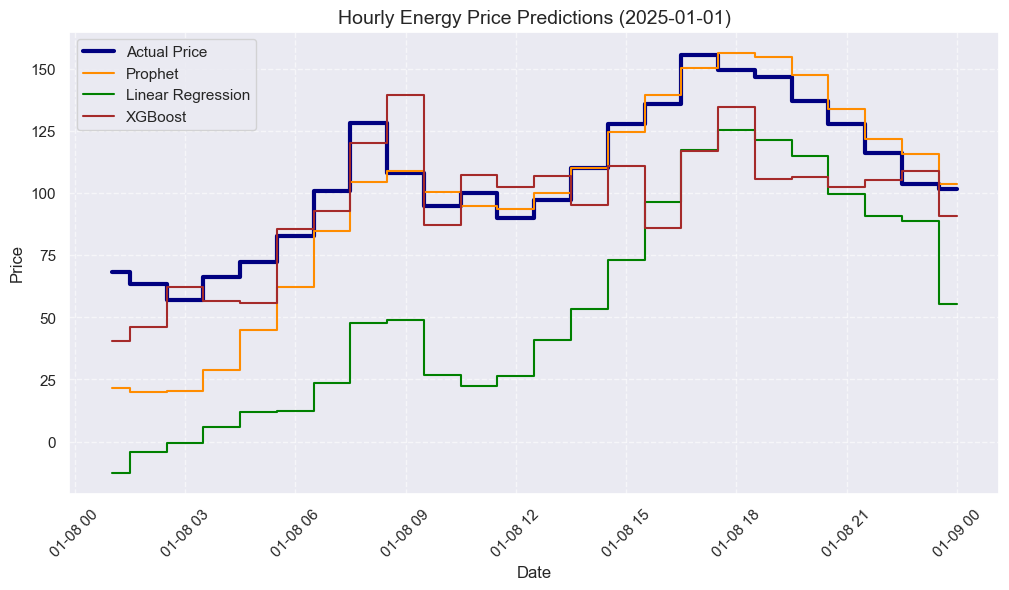

Prophet RMSE: 19.744463027259638
Linear Regression RMSE: 55.927562472097804
XGBoost RMSE: 21.55860779615894



18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-10 00:00:00 to 2025-01-11 00:00:00


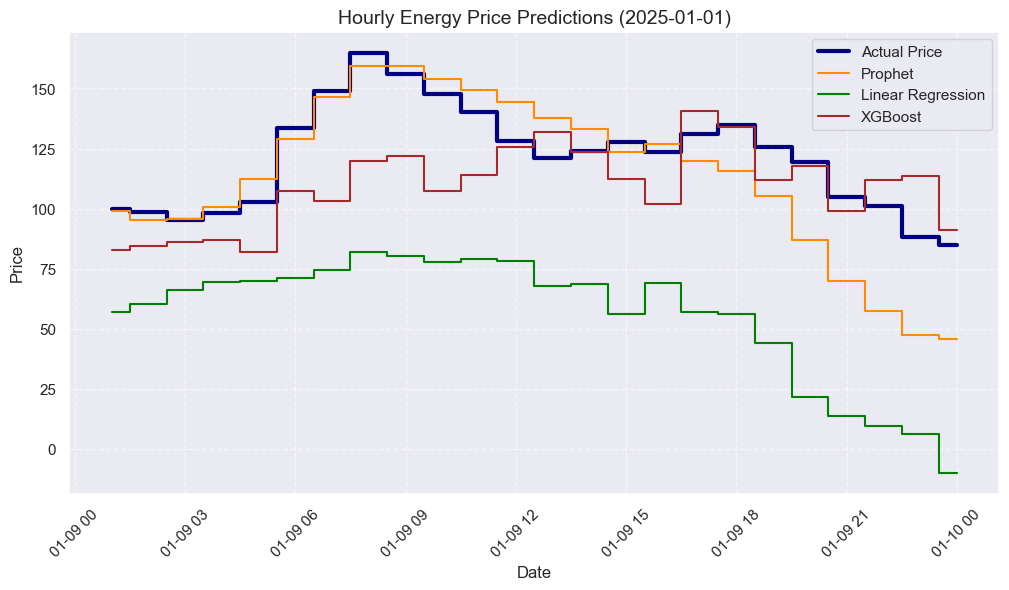

Prophet RMSE: 19.621882769225593
Linear Regression RMSE: 68.67620529205583
XGBoost RMSE: 21.75630703477411



18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-11 00:00:00 to 2025-01-12 00:00:00


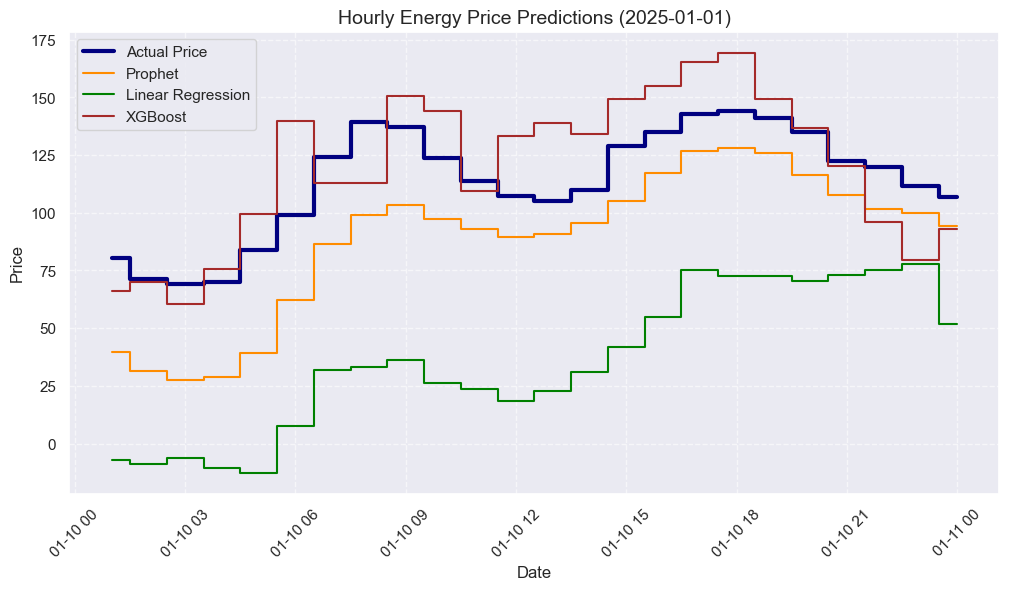

Prophet RMSE: 28.001944712875137
Linear Regression RMSE: 79.94959047260544
XGBoost RMSE: 20.280445760411677



18:31:55 - cmdstanpy - INFO - Chain [1] start processing
18:33:13 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-12 00:00:00 to 2025-01-13 00:00:00


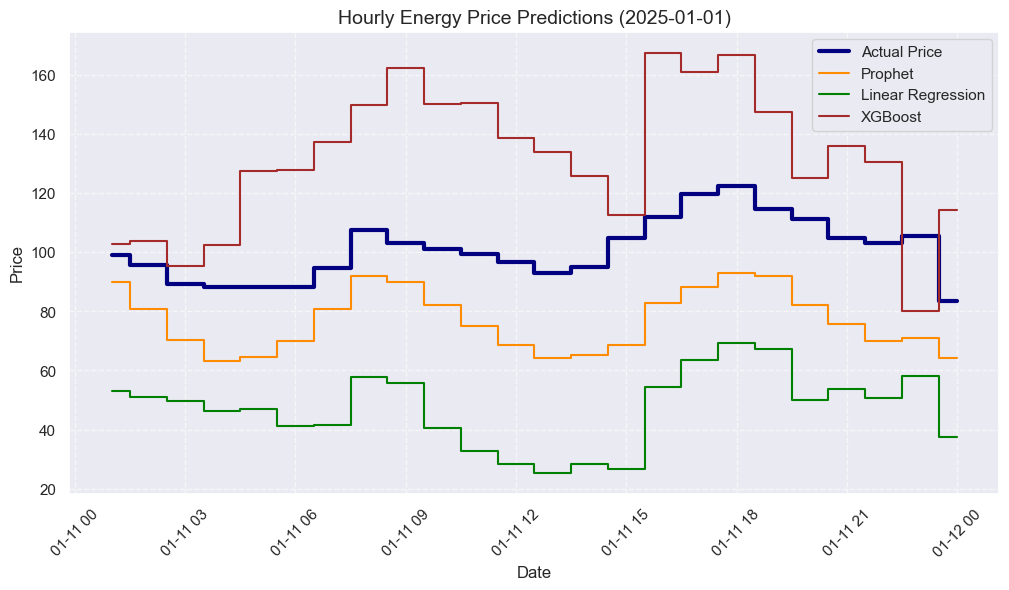

Prophet RMSE: 25.150195814308507
Linear Regression RMSE: 54.71808425747326
XGBoost RMSE: 36.148635074346984



18:33:33 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-12 23:00:00 to 2025-01-13 23:00:00


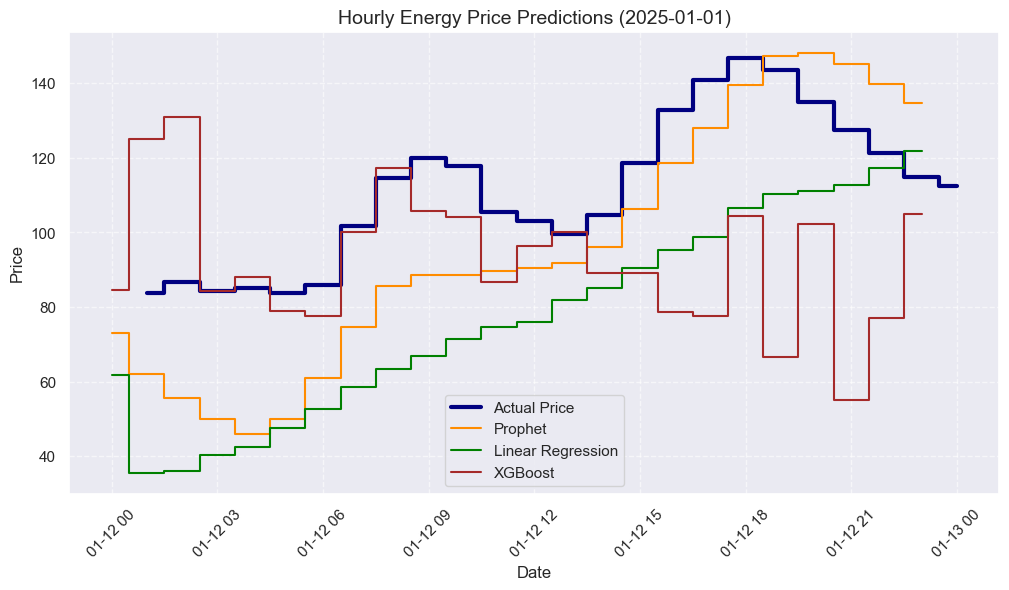

Prophet RMSE: 25.72422468275682
Linear Regression RMSE: 38.04193833656133
XGBoost RMSE: 34.83002115936174



18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-14 00:00:00 to 2025-01-15 00:00:00


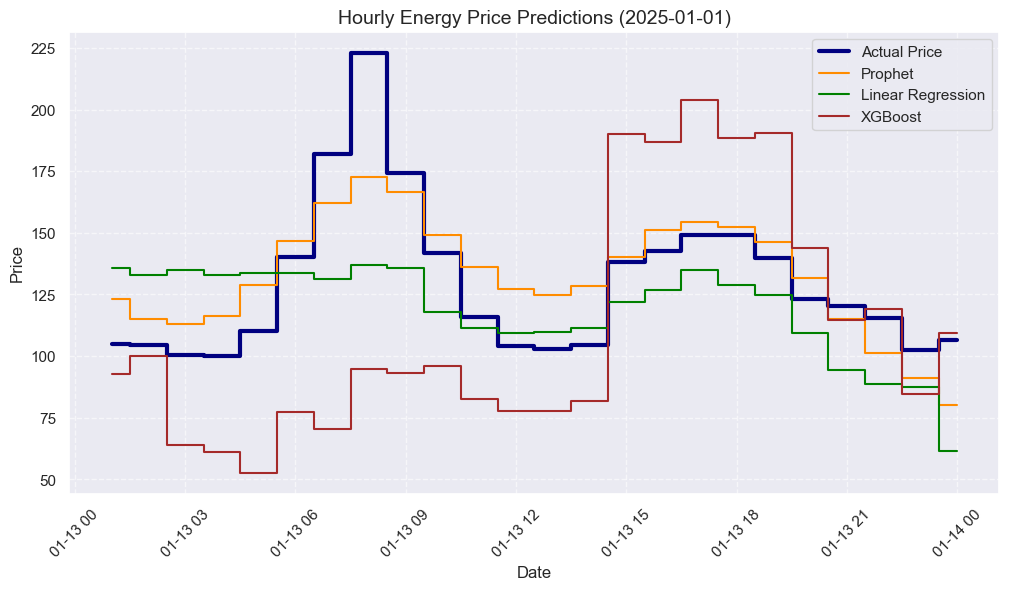

Prophet RMSE: 17.71323879788905
Linear Regression RMSE: 30.2343139971813
XGBoost RMSE: 51.35350929035211



18:36:02 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-15 00:00:00 to 2025-01-16 00:00:00


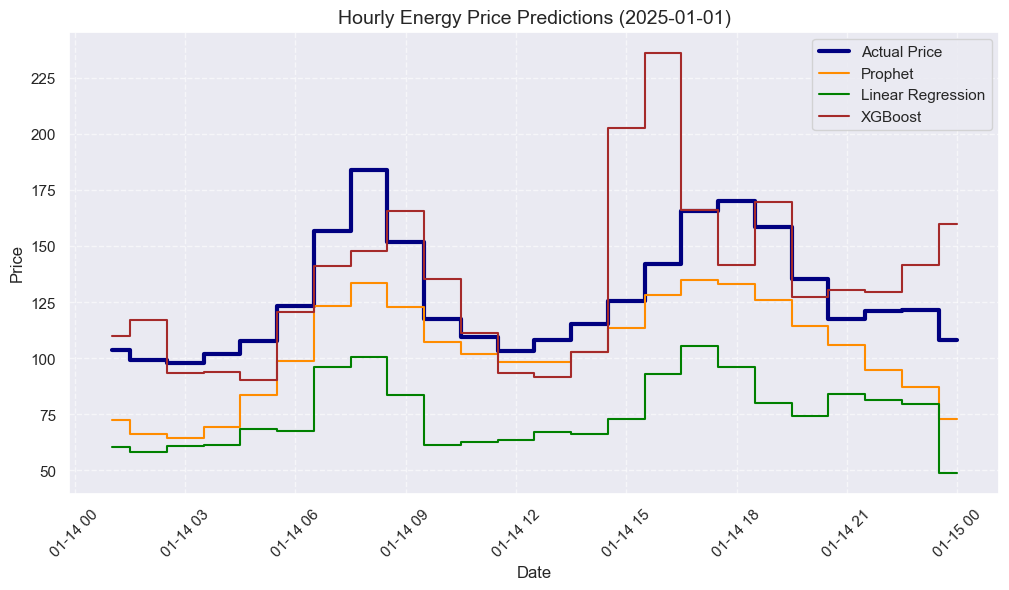

Prophet RMSE: 27.198488360268325
Linear Regression RMSE: 53.877575054571196
XGBoost RMSE: 30.665960489505057



18:37:22 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-16 00:00:00 to 2025-01-17 00:00:00


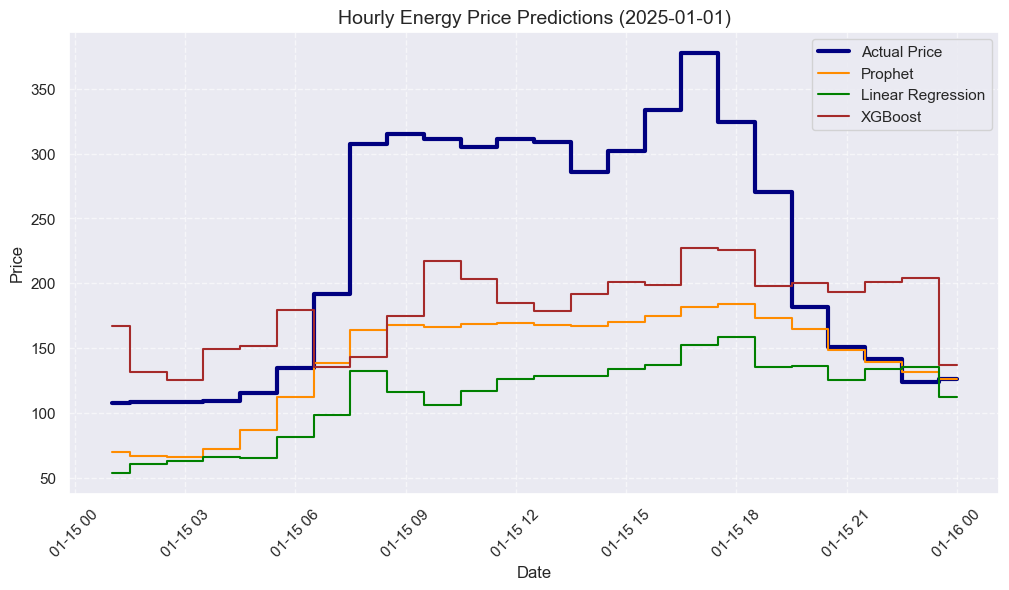

Prophet RMSE: 103.53157134287007
Linear Regression RMSE: 133.68862168373857
XGBoost RMSE: 90.93289573840303



18:38:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-17 00:00:00 to 2025-01-18 00:00:00


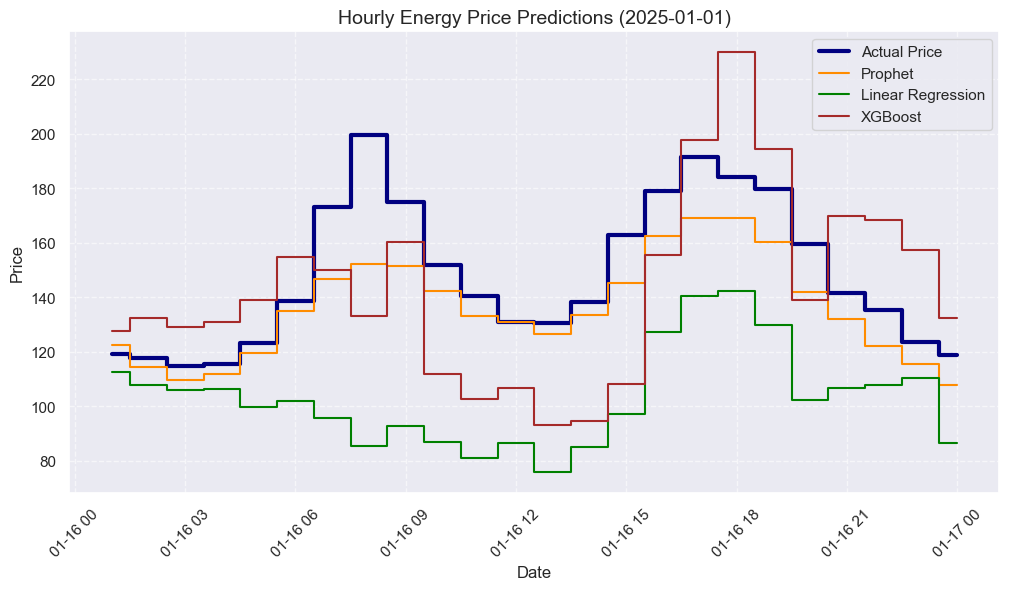

Prophet RMSE: 16.082833659993234
Linear Regression RMSE: 51.58644701761661
XGBoost RMSE: 30.883469146631814



18:40:08 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-18 00:00:00 to 2025-01-19 00:00:00


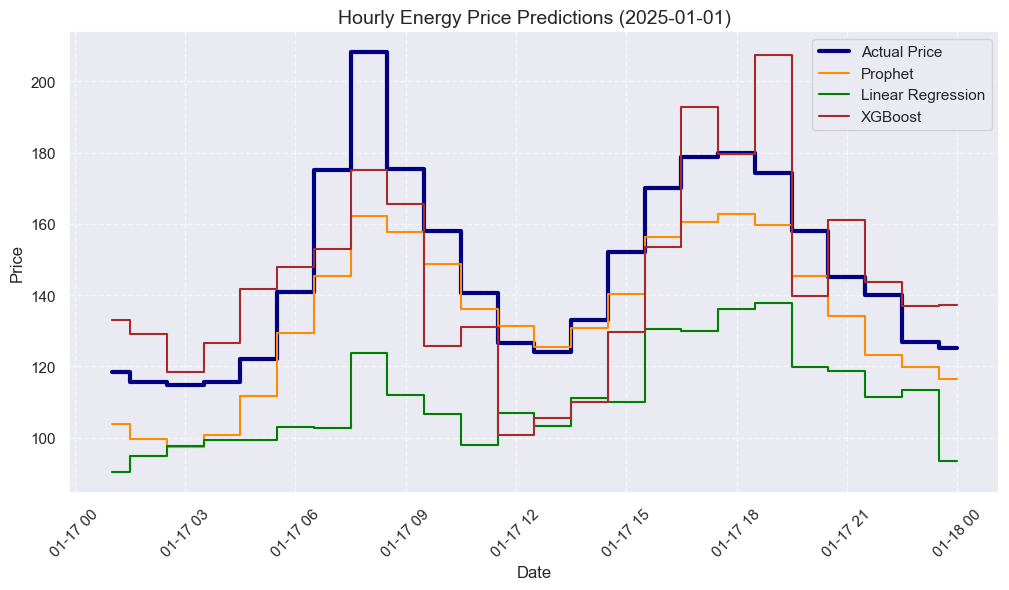

Prophet RMSE: 16.475099096640776
Linear Regression RMSE: 40.28786108601674
XGBoost RMSE: 18.50562064542756



18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:39 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-19 00:00:00 to 2025-01-20 00:00:00


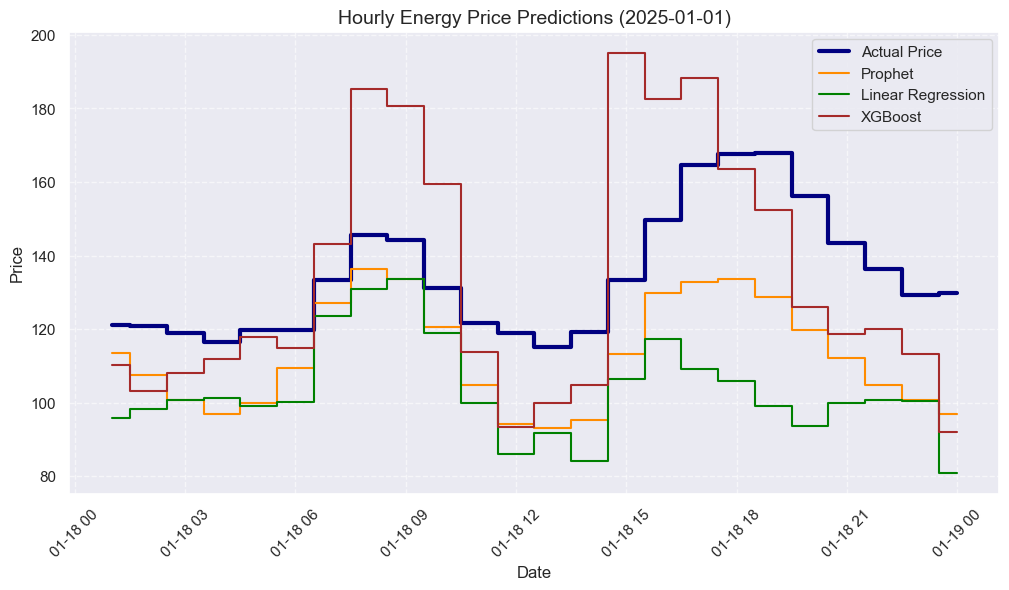

Prophet RMSE: 23.644320284995516
Linear Regression RMSE: 35.409700544252615
XGBoost RMSE: 24.80377414726877



18:42:59 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-19 23:00:00 to 2025-01-20 23:00:00


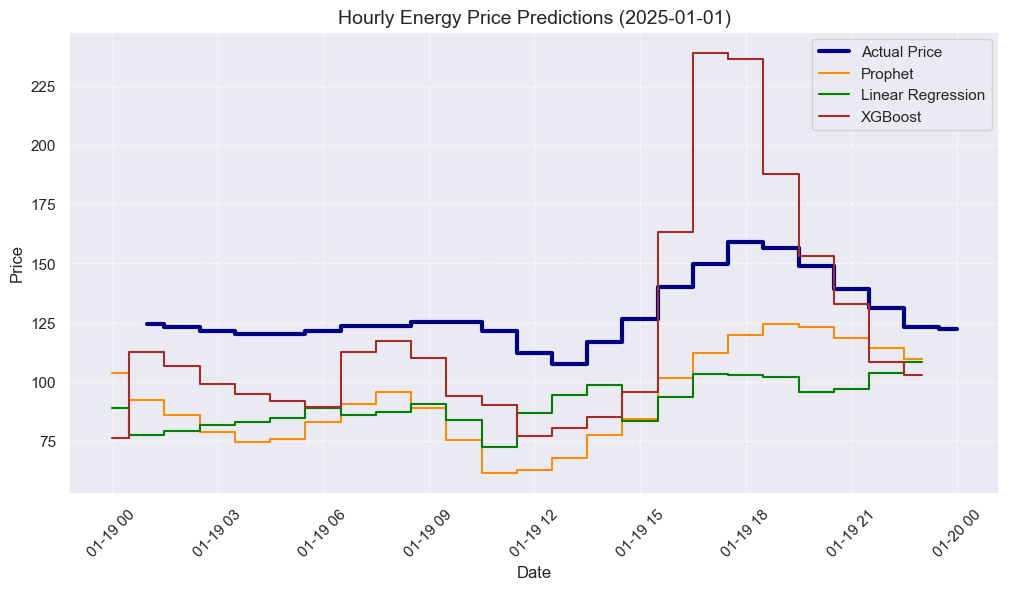

Prophet RMSE: 38.24711794455963
Linear Regression RMSE: 39.52811565348564
XGBoost RMSE: 34.520338143729745



18:44:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:25 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-21 00:00:00 to 2025-01-22 00:00:00


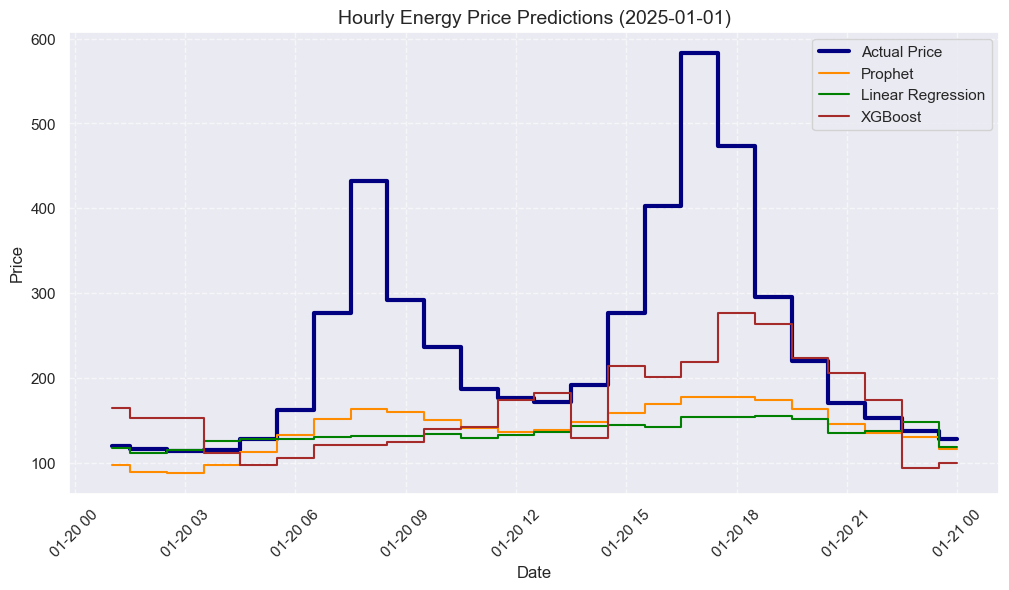

Prophet RMSE: 138.6975998662269
Linear Regression RMSE: 152.08062159929565
XGBoost RMSE: 128.28651330802958



18:45:45 - cmdstanpy - INFO - Chain [1] start processing
18:46:49 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-22 00:00:00 to 2025-01-23 00:00:00


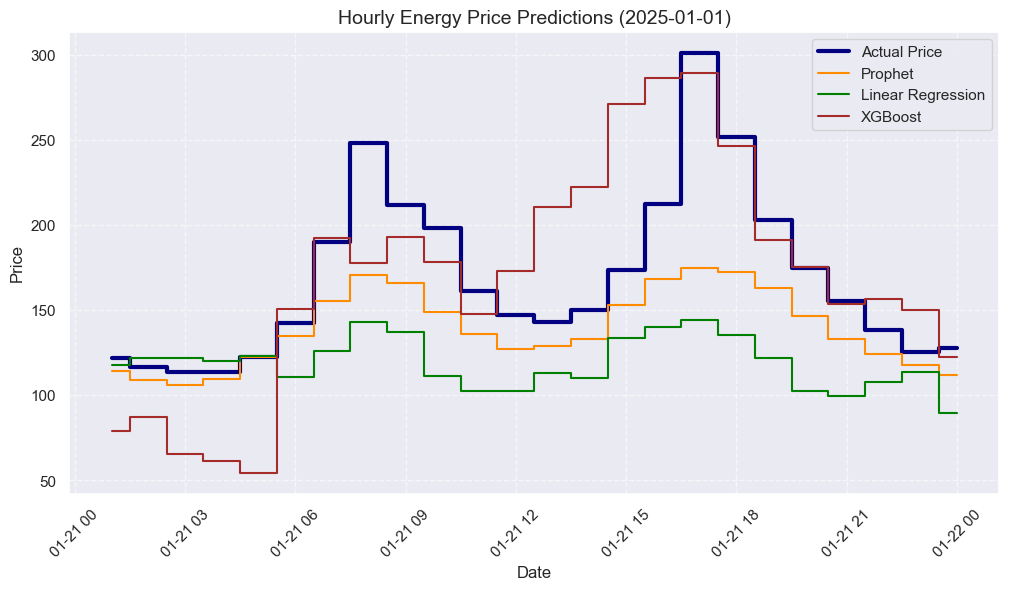

Prophet RMSE: 41.60917746772919
Linear Regression RMSE: 64.47702741326621
XGBoost RMSE: 43.3156946594785



18:47:10 - cmdstanpy - INFO - Chain [1] start processing
18:48:16 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-23 00:00:00 to 2025-01-24 00:00:00


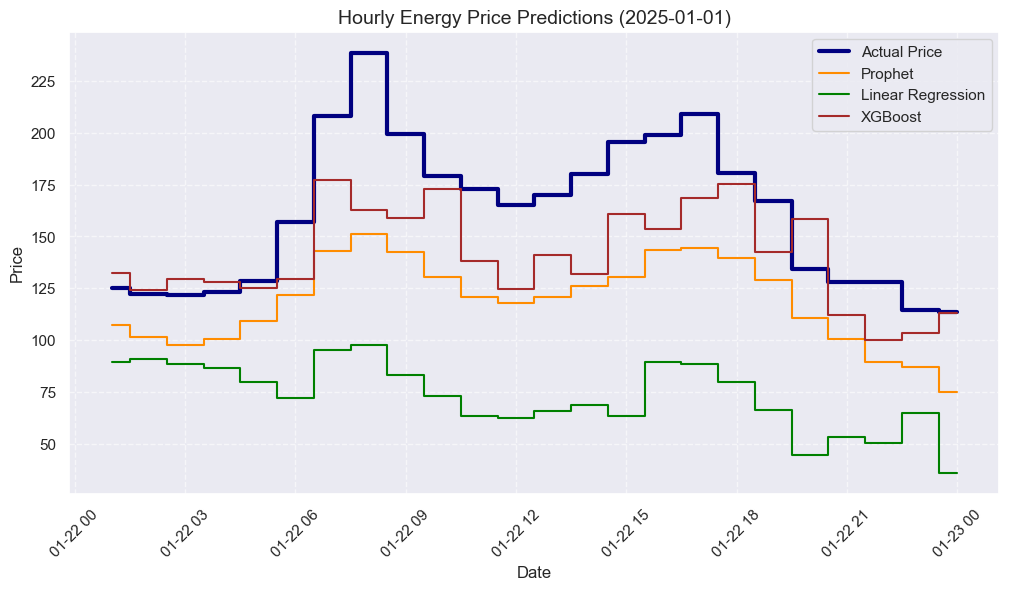

Prophet RMSE: 46.05947073584951
Linear Regression RMSE: 93.58164971797375
XGBoost RMSE: 30.667456197481098



18:48:36 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# =============================================================================
# Constants and Configurations
# =============================================================================

# Forecasting window settings
HOURS_IN_LAST_MONTH = 24 * 31  # Assuming 31 days in the last month
WINDOW_SIZE = 24             # Forecasting window of 24 hours

# Columns to use from the datasets
COLUMNS = [
    "Price", "Hydro", "Pumped storage generation", "Solar", 
    "Wind offshore", "Wind onshore", "temperature_2m", "precipitation", 
    "wind_speed_100m", "direct_radiation"
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "hour", "dayofyear", "dayofweek",
    "Hydro", "Pumped storage generation",
    "Solar", "Wind offshore", "Wind onshore",
    "temperature_2m", "precipitation", "wind_speed_100m", "direct_radiation"
]

XGB_hyp_params = {
    "base_score": 0.380924762889507,
    # "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

# =============================================================================
# Data Preparation
# =============================================================================

# Split the data into training and benchmarking sets
training_set = merged_df.iloc[:-HOURS_IN_LAST_MONTH][COLUMNS]
benchmarking_set = combined_df.iloc[-HOURS_IN_LAST_MONTH:].copy()

# List to hold RMSE values for each forecasting window
rmses = []

# =============================================================================
# Rolling Forecast Loop
# =============================================================================

for i in range(0, len(benchmarking_set) - WINDOW_SIZE, WINDOW_SIZE):
    # ------------------------- Prophet Model -------------------------
    # Initialize the Prophet model with custom features.
    prophet_model = init_prophet_model(FINAL_FEATURES)
    
    # Extract actual price values for the current 24-hour window.
    y_actual = benchmarking_set.iloc[i:i + WINDOW_SIZE]["Price"]

    # Extend the training data with any benchmarking data available before the current window.
    train_extended = pd.concat((training_set.copy(), benchmarking_set.iloc[:i]))
    train_extended = extend_by_predictions_and_samples(train_extended, train_extended.index[-1])
    train_extended_features = create_features(train_extended.copy())

    # Prepare data for Prophet: 
    # - The forecast dataframe requires a datetime column named "ds".
    prophet_forecast_data = (
        train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]
        .reset_index()
        .rename(columns={"index": "ds"})
    )

    # Prepare the training data for Prophet.
    prophet_training_data = (
        train_extended_features.iloc[:-WINDOW_SIZE][["Price"] + FINAL_FEATURES]
        .rename(columns={"Price": "y"})
        .reset_index()
        .rename(columns={"index": "ds"})
        .dropna()
    )

    # Fit the Prophet model and make predictions.
    prophet_model.fit(prophet_training_data)
    prophet_forecast = prophet_model.predict(prophet_forecast_data)["yhat"]

    # --------------------- Linear Regression Model ---------------------
    X_train_lr = train_extended_features.iloc[:-WINDOW_SIZE][FINAL_FEATURES]
    y_train_lr = train_extended_features.iloc[:-WINDOW_SIZE]["Price"]
    X_forecast_lr = train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]

    lr_model = LinearRegression()
    lr_model.fit(X_train_lr, y_train_lr)
    lr_forecast = lr_model.predict(X_forecast_lr)

    # ------------------------ XGBoost Model ------------------------
    xgb_model = XGBRegressor(**XGB_hyp_params)
    xgb_model.fit(X_train_lr, y_train_lr)
    xgb_forecast = xgb_model.predict(X_forecast_lr)

    # -------------------------- Plotting --------------------------
    # Determine the forecast time window for labeling the plot.
    start_time = train_extended.index[-1]
    end_time = start_time + timedelta(hours=WINDOW_SIZE)
    print(f"Prediction from {start_time} to {end_time}")

    # Adjusting x-ticks to properly align within the given range
    plt.figure(figsize=(12, 6))
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.step(y_actual.index, y_actual,linewidth=3, where="mid", label="Actual Price", color="navy")
    plt.step(prophet_forecast_data["ds"], prophet_forecast, linewidth=1.5, where="mid", label="Prophet", color="darkorange")
    plt.step(X_forecast_lr.index, lr_forecast, linewidth=1.5, where="mid", label="Linear Regression", color="green")
    plt.step(X_forecast_lr.index, xgb_forecast, linewidth=1.5, where="mid", label="XGBoost", color="brown")

    # Formatting the x-axis with properly aligned ticks
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title("Hourly Energy Price Predictions (2025-01-01)", fontsize=14)

    plt.xticks(rotation=45)
    plt.legend(fontsize=11)
    plt.show()

    # --------------------- RMSE Computation ---------------------
    prophet_rmse = mean_squared_error(y_actual, prophet_forecast) ** 0.5
    lr_rmse = mean_squared_error(y_actual, lr_forecast) ** 0.5
    xgb_rmse = mean_squared_error(y_actual, xgb_forecast) ** 0.5

    print(f"Prophet RMSE: {prophet_rmse}")
    print(f"Linear Regression RMSE: {lr_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}\n")

    rmses.append((prophet_rmse, lr_rmse, xgb_rmse))

# =============================================================================
# Average RMSE Reporting
# =============================================================================

avg_rmse = tuple(sum(x) / len(rmses) for x in zip(*rmses))
print(f"Average RMSEs - Prophet: {avg_rmse[0]}, Linear Regression: {avg_rmse[1]}, XGBoost: {avg_rmse[2]}")


## 5. Results
We trained and evaluated three models: Linear Regression, XGBoost, and Prophet, comparing them based on MAE, MSE, RMSE and MAPE.

XGBoost performed the worst among the three models, showing the highest RMSE and MAE. While XGBoost is a complex machine learning algorithm for tabular data, it is not inherently designed for time-series forecasting. Unlike models specifically tailored to capture temporal dependencies, XGBoost requires extensive feature engineering, such as lag variables and rolling statistics, to approximate time-dependent patterns. Despite tuning hyperparameters to improve performance, the model struggled to generalize well over unseen time periods. However, the computational time for XGBoost was relatively short, taking only a few seconds, which made it a viable option for testing. Its training time was not a significant constraint, but its inability to effectively capture long-term trends and seasonal cycles made it less suitable for this task.

Prophet, on the other hand, outperformed the other models by achieving the lowest RMSE and MAE. Unlike XGBoost, Prophet is specifically designed for time-series forecasting and naturally incorporates seasonality, trend changes, and external regressors without requiring extensive feature engineering. The ability to model holidays and other special events allowed Prophet to adapt to irregular fluctuations in energy prices that were influenced by external factors such as national holidays or changes in market demand. The model’s use of multiplicative seasonality further improved accuracy, as energy prices exhibit percentage-based fluctuations rather than purely additive changes. However, a key consideration is that Prophet had by far the highest computational time, often taking multiple minutes to train, compared to the seconds it took for Linear Regression and XGBoost. While Prophet's accuracy was superior, its long training time makes it less practical in environments requiring frequent testing or fast iteration.

Linear Regression performed better than expected, with results that were relatively close to those of Prophet. One key reason for its strong performance was the presence of moving averages, which helped smooth short-term fluctuations in the energy prices. By incorporating moving averages, the model was able to capture a form of seasonality indirectly, as the smoothed data preserved some of the cyclical patterns present in energy prices. This approach allowed Linear Regression to approximate longer-term trends while reducing noise from sudden price spikes or irregular fluctuations.

However, despite the benefits of moving averages, Linear Regression still struggled to fully capture more complex seasonal effects and abrupt trend changes. Unlike Prophet, which explicitly models multiple seasonal components and adjusts for holiday effects, Linear Regression could only approximate these patterns through indirect smoothing techniques. As a result, while the model performed better than XGBoost, it was still outperformed by Prophet, which could natively account for seasonality, trend shifts, and external regressors.
Overall, Prophet emerged as the best model due to its ability to handle seasonal effects, holidays, and external variables naturally. Linear Regression performed better than expected because of the strong linear structure in energy prices, whereas XGBoost struggled due to its lack of native time-series modeling capabilities and its sensitivity to short-term fluctuations.


## Final Prediction 18.02.2025 00:00:00 - 19.02.2025 00:00:00

In [ ]:
# from src.final_prediction import fill_up_e_prices, fill_up_energy_mix, fetch_forecast_and_update_csv
# # fill_up_e_prices()
# # fill_up_energy_mix()
# # fetch_forecast_and_update_csv()
# 

# # Columns to use from the datasets
# COLUMNS = [
#     "Price", "Hydro", "Pumped storage generation", "Solar", 
#     "Wind offshore", "Wind onshore", "temperature_2m", "precipitation", 
#     "wind_speed_100m", "direct_radiation"
# ]

# # Final features used for model training and forecasting
# FINAL_FEATURES = [
#     "hour", "dayofyear", "dayofweek",
#     "Hydro", "Pumped storage generation",
#     "Solar", "Wind offshore", "Wind onshore",
#     "temperature_2m", "precipitation", "wind_speed_100m", "direct_radiation"
# ]
# # =============================================================================
# # Data Preparation
# # =============================================================================


# start_date = '2025-02-18 00:00:00'
# end_date = '2025-02-18 23:00:00'
    
# # ------------------------- Prophet Model -------------------------
# # Initialize the Prophet model with custom features.
# prophet_model = init_prophet_model(FINAL_FEATURES)

# # Extend the training data with any benchmarking data available before the current window.
# feature_df = create_features(merged_df[COLUMNS])

# # Split the data into training and benchmarking sets
# training_set = feature_df.loc[:start_date]
# prediction_set = feature_df.loc[start_date:end_date]

# # Prepare the training data for Prophet.
# # - The forecast dataframe requires a datetime column named "ds" and our target columns to be named "y".
# prophet_training_data = (
#     training_set[["Price"] + FINAL_FEATURES]
#     .rename(columns={"Price": "y"})
#     .reset_index()
#     .rename(columns={"index": "ds"})
#     .dropna()
# )

# # Prepare data for Prophet forecasting: 
# # - The forecast dataframe requires a datetime column named "ds".
# prophet_forecast_data = (
#     prediction_set[FINAL_FEATURES]
#     .reset_index()
#     .rename(columns={"index": "ds"})
# )

# # Fit the Prophet model and make predictions.
# prophet_model.fit(prophet_training_data)
# prophet_forecast = prophet_model.predict(prophet_forecast_data)["yhat"]


# prophet_forecast.to_csv("forecast.csv", index=True)


                     Hydro  Pumped storage generation
2025-01-28 01:00:00  1.748                      0.001
2025-01-28 02:00:00  1.771                      0.006
2025-01-28 03:00:00  1.803                      0.030
2025-01-28 04:00:00  1.789                      0.096
2025-01-28 05:00:00  1.812                      0.058
...                    ...                        ...
2025-02-11 19:00:00    NaN                        NaN
2025-02-11 20:00:00    NaN                        NaN
2025-02-11 21:00:00    NaN                        NaN
2025-02-11 22:00:00    NaN                        NaN
2025-02-11 23:00:00    NaN                        NaN

[359 rows x 2 columns]
None value detected for ts:  2025-02-06 00:00:00
None value detected for ts:  2025-02-06 01:00:00
None value detected for ts:  2025-02-06 02:00:00
None value detected for ts:  2025-02-06 03:00:00
None value detected for ts:  2025-02-06 04:00:00
None value detected for ts:  2025-02-06 05:00:00
None value detected for ts:  2025-